In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune
import pyxu_diffops.operator as px_diffops

from scipy.stats import pearsonr

/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/dhamm/miniconda3/envs/bayes-plasma-tomo/lib/python3.12/site-packages/pyxu/info/plug

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
Tmat_unif_fine_1e4 = sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_mat_artificial_fine_random_1e4.npz')
Tmat_unif_coarse_1e4 = sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_mat_artificial_coarse_random_1e4.npz')
LoS_params_unif_1e4 = np.load('../../tomo_fusion/forward_model/LoS_params_artificial_random_1e4.npy')

Tmat_fine = sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr_fine_grid.npz')
Tmat_coarse = sp.load_npz('../../tomo_fusion/forward_model/geometry_matrices/sparse_geometry_matrix_sxr.npz')
LoS_params = np.load('../../tomo_fusion/forward_model/sxr_LoS_params.npy')

In [4]:
results_dirs = ["../phantom_analysis/uq_study_results/sigma005", "../phantom_analysis/uq_study_results/sigma01",
                "../phantom_analysis/uq_study_results/sigma005005", "../phantom_analysis/uq_study_results/sigma005005new"]

aggregate_data = []
for res_dir in results_dirs:
    aggregate_data.append(np.load(res_dir + "/postprocessed_data.npy", allow_pickle=True).item())

# Paper plots

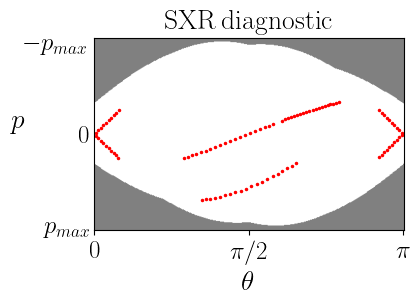

In [6]:
params = LoS_params
markersize = 3
tcv_mask_finesse = round(300)
pmin = np.min(params[:, 0])
prange = np.max(params[:, 0]) - np.min(params[:, 0])
# pmax corresponding to tcv geometry
tcv_pmax = 0.5646 + 0.25
PT_intersecting_tcv_mask = np.load('../../tomo_fusion/forward_model/tcv_mask_sinogram.npy')
plt.figure(figsize=(4,2.5))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
# plot tcv mask
#plt.imshow(PT_intersecting_tcv_mask, origin="upper", aspect="auto", cmap="gray", alpha=0.5)
PT_intersecting_tcv_mask = PT_intersecting_tcv_mask.astype(float)
PT_intersecting_tcv_mask[PT_intersecting_tcv_mask<0.1] = 0.5
plt.imshow(PT_intersecting_tcv_mask, origin="upper", aspect="auto", cmap="gray", vmin=0)
# plot considered LoS configuration
scaling_factor_p = prange / (2*tcv_pmax)  # 2*pmax/(...)
scaling_factor_theta = np.max(params[:, 1]) / np.pi
ps = (params[:, 0]+np.abs(np.min(params[:, 0])))/np.max(params[:, 0]+np.abs(np.min(params[:, 0])))*(tcv_mask_finesse-1)*scaling_factor_p
# shift ps
#ps += eps / (2*pmax + 2*eps) * (tcv_mask_finesse-1)
ps += (tcv_pmax + pmin) / (2 * tcv_pmax) * (tcv_mask_finesse-1)
thetas = params[:, 1]/np.max(params[:, 1])*(tcv_mask_finesse-1)*scaling_factor_theta
for i in range(params.shape[0]):
    #a=0
    plt.plot(thetas[i], ps[i], "r", marker=".", markersize=markersize)
plt.xticks([0, tcv_mask_finesse/2, tcv_mask_finesse-1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=18)
plt.tick_params(axis='y',length=0)
plt.yticks([5, tcv_mask_finesse/2, tcv_mask_finesse-10], [r'$-p_{max}$', r'$0$', r'$p_{max}$'], fontsize=18)
#plt.yticks([])
plt.xlabel(r"$\theta$", fontsize=20)
plt.ylabel(r"$p$", rotation=0, fontsize=20, labelpad=5)
plt.title(r"$\mathrm{SXR\,diagnostic}$", fontsize=20, color="k")

#plt.savefig('../figures/sxr_diag_sinogram.eps', format='eps', bbox_inches="tight")


plt.show()

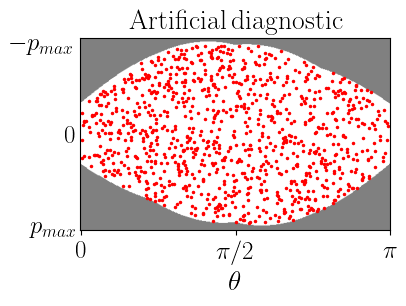

In [7]:
plot_idxs=np.random.choice(int(1e4), int(1e3), replace=False)

params = LoS_params_unif_1e4[plot_idxs, :]
markersize = 3
tcv_mask_finesse = round(300)
pmin = np.min(params[:, 0])
prange = np.max(params[:, 0]) - np.min(params[:, 0])
# pmax corresponding to tcv geometry
tcv_pmax = 0.5646 + 0.25
PT_intersecting_tcv_mask = np.load('../../tomo_fusion/forward_model/tcv_mask_sinogram.npy')
plt.figure(figsize=(4,2.5))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
# plot tcv mask

#plt.imshow(PT_intersecting_tcv_mask, origin="upper", aspect="auto", cmap="gray", alpha=0.5)
#PT_intersecting_tcv_mask[PT_intersecting_tcv_mask==False] = 0.2
PT_intersecting_tcv_mask = PT_intersecting_tcv_mask.astype(float)
PT_intersecting_tcv_mask[PT_intersecting_tcv_mask<0.1] = 0.5
plt.imshow(PT_intersecting_tcv_mask, origin="upper", aspect="auto", cmap="gray", vmin=0)
# plot considered LoS configuration
scaling_factor_p = prange / (2*tcv_pmax)  # 2*pmax/(...)
scaling_factor_theta = np.max(params[:, 1]) / np.pi
ps = (params[:, 0]+np.abs(np.min(params[:, 0])))/np.max(params[:, 0]+np.abs(np.min(params[:, 0])))*(tcv_mask_finesse-1)*scaling_factor_p
# shift ps
#ps += eps / (2*pmax + 2*eps) * (tcv_mask_finesse-1)
ps += (tcv_pmax + pmin) / (2 * tcv_pmax) * (tcv_mask_finesse-1)
thetas = params[:, 1]/np.max(params[:, 1])*(tcv_mask_finesse-1)*scaling_factor_theta
for i in range(params.shape[0]):
    #a=0
    plt.plot(thetas[i], ps[i], "r", marker=".", markersize=markersize)
plt.xticks([0, tcv_mask_finesse/2, tcv_mask_finesse-1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=18)
plt.tick_params(axis='y',length=0)
plt.yticks([5, tcv_mask_finesse/2, tcv_mask_finesse-10], [r'$-p_{max}$', r'$0$', r'$p_{max}$'], fontsize=18)
#plt.yticks([])
plt.xlabel(r"$\theta$", fontsize=20)
plt.ylabel(r"$\phantom{p}$", rotation=0, fontsize=20, labelpad=5)
plt.title(r"$\mathrm{Artificial\,diagnostic}$", fontsize=20, color="k")

#plt.savefig('../figures/art_diag_sinogram.eps', format='eps', bbox_inches="tight")


plt.show()

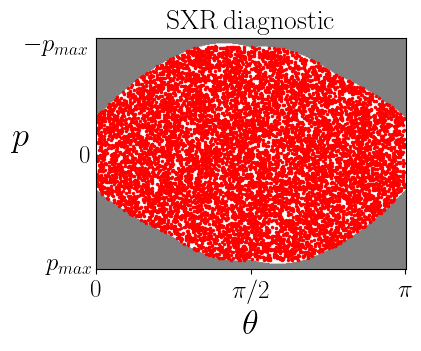

In [8]:
params = LoS_params_unif_1e4
markersize = 3
tcv_mask_finesse = round(300)
pmin = np.min(params[:, 0])
prange = np.max(params[:, 0]) - np.min(params[:, 0])
# pmax corresponding to tcv geometry
tcv_pmax = 0.5646 + 0.25
PT_intersecting_tcv_mask = np.load('../../tomo_fusion/forward_model/tcv_mask_sinogram.npy')
plt.figure(figsize=(4,3))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
# plot tcv mask
plt.imshow(PT_intersecting_tcv_mask, origin="upper", aspect="auto", cmap="gray", alpha=0.5)
# plot considered LoS configuration
scaling_factor_p = prange / (2*tcv_pmax)  # 2*pmax/(...)
scaling_factor_theta = np.max(params[:, 1]) / np.pi
ps = (params[:, 0]+np.abs(np.min(params[:, 0])))/np.max(params[:, 0]+np.abs(np.min(params[:, 0])))*(tcv_mask_finesse-1)*scaling_factor_p
# shift ps
#ps += eps / (2*pmax + 2*eps) * (tcv_mask_finesse-1)
ps += (tcv_pmax + pmin) / (2 * tcv_pmax) * (tcv_mask_finesse-1)
thetas = params[:, 1]/np.max(params[:, 1])*(tcv_mask_finesse-1)*scaling_factor_theta
for i in range(params.shape[0]):
    #a=0
    plt.plot(thetas[i], ps[i], "r", marker=".", markersize=markersize)
plt.xticks([0, tcv_mask_finesse/2, tcv_mask_finesse-1], [r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=18)
plt.tick_params(axis='y',length=0)
plt.yticks([5, tcv_mask_finesse/2, tcv_mask_finesse-10], [r'$-p_{max}$', r'$0$', r'$p_{max}$'], fontsize=18)
#plt.yticks([])
plt.xlabel(r"$\theta$", fontsize=25)
plt.ylabel(r"$p$", rotation=0, fontsize=25, labelpad=5)
plt.title(r"$\mathrm{SXR\,diagnostic}$", fontsize=20, color="k")

plt.show()

In [9]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples/psis.npy')
sxr_samples  = np.load('../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
alphas  = np.load('../dataset_generation/sxr_samples/alpha_random_values.npy')
trim_vals = np.load('../dataset_generation/sxr_samples/trimming_values.npy')
random_peak_vals  = np.load('../dataset_generation/sxr_samples/peak_values_gaussian_background.npy')

In [10]:
idx = 23

sample = sxr_samples[idx, :, :]
psi = psis[idx, :, :]

uq_data_dir = "../phantom_analysis/uq_study_results/sigma005"
data_idx=0

uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()

True alpha 0.0014038312904359402
Estimated alpha 0.004641588833612777


In [15]:
alphas = [1e-4, 1e-2, 1e0]
maps_sxr = []
maps_sxr_stats = []

sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
ground_truth = sample

for alpha_ in alphas:
    f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                     sigma_err=uq_data_idx["sigma_err"]/5, reg_fct_type="anisotropic",
                                                     alpha=alpha_,#uq_data_idx["alpha"],
                                                     plot=False,
                                                     seed=idx)

    mask_core = tomo_helps.define_core_mask(psi=psi_downscaled, dim_shape=(120,40), trim_values_x=trim_vals[idx])

    im_MAP_sxr = bcomp.compute_MAP(f, g, 0.1, with_pos_constraint=True, clipping_mask=mask_core, show_progress=True)

    ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False,
                                                    mode='edge')
    mse_map_core = np.sqrt(np.mean((ground_truth_downsampled[mask_core] -im_MAP_sxr[mask_core]) ** 2))

    prad_map_core = tomo_helps.compute_radiated_power(im_MAP_sxr, mask_core, sampling=uq_data_idx["sampling"])
    true_prad_core = tomo_helps.compute_radiated_power(ground_truth_downsampled, mask_core, uq_data_idx["sampling"])
    prad_rel_err = (prad_map_core-true_prad_core)/true_prad_core

    maps_sxr.append(im_MAP_sxr)
    maps_sxr_stats.append(np.array([mse_map_core, 100*prad_rel_err]))


INFO -- [2025-02-26 16:52:24.454433] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:52:24.777785] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.008560] Iteration 2_000
	iteration: 2000
	N_iter: 2001
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.094466] Iteration 2_387
	iteration: 2387
	N_iter: 2388
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.094969] Stopping Criterion satisfied -> END
INFO -- [2025-02-26 16:52:25.157731] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.383408] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.400566] Iteration 1_071
	iteration: 1071
	N_iter: 1072
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.401109] Stopping Criterion satisfied -> END
INFO -- [2025-02-26 16:52:25.448853] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:52:25.569734] Iteration 541
	iteration: 541
	N_iter: 542
	Rel

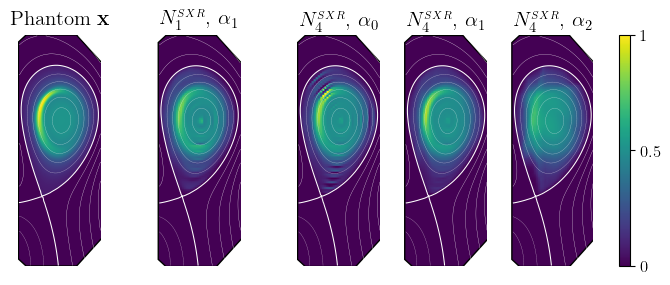

In [26]:
sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')

std_max = 0.25

# create figure
nb_subplots = 5
fig_width = 1.6*(nb_subplots)
width_ratios = [1]*nb_subplots
width_ratios = [1, 0.1, 1, 0.1, 1, 1, 1.525]
fig, ax = plt.subplots(1, 7, figsize=(fig_width, 3), width_ratios=width_ratios)
plt.subplots_adjust(wspace=0.35)
ax_counter = 0

tomo_plots.plot_profile(sample, tcv_plot_clip=True, contour_image=psi,
                             ax=ax[0], colorbar=False, contour_color="w", vmax=1, aspect="auto", levels=12)
ax[0].set_title(r"$\mathrm{Phantom}\;\mathbf{x}$", fontsize=15, y=1.01)

ax[1].axis("off")

tomo_plots.plot_profile(uq_data_idx["im_MAP"], tcv_plot_clip=True, contour_image=psi_downscaled,
                             ax=ax[2], colorbar=False, contour_color="w", vmax=1, aspect="auto", levels=12)
ax[2].set_title(r"$N_1^{\scriptscriptstyle SXR},\,\alpha_1$", fontsize=15, y=1.01)

ax[3].axis("off")

tomo_plots.plot_profile(maps_sxr[0], tcv_plot_clip=True, contour_image=psi_downscaled, levels=12,vmax=1, aspect="auto",
               ax=ax[4], colorbar=False, contour_color="w")
ax[4].set_title(r"$N_4^{\scriptscriptstyle SXR},\,\alpha_0$", fontsize=15)


tomo_plots.plot_profile(maps_sxr[1], tcv_plot_clip=True, contour_image=psi_downscaled, levels=12,vmax=1, aspect="auto",
               ax=ax[5], colorbar=False, contour_color="w")
ax[5].set_title(r"$N_4^{\scriptscriptstyle SXR},\,\alpha_1$", fontsize=15)

cbar_tick_params={"labelsize":12, "yticks":[0,0.5,1], "yticklabels":[r"$0$",  r"$0.5$", r"$1$"]}
tomo_plots.plot_profile(maps_sxr[2], tcv_plot_clip=True, contour_image=psi_downscaled, levels=12,vmax=1, aspect="auto",
               ax=ax[6], colorbar=True, contour_color="w", cbar_tick_params=cbar_tick_params, pad_cbar=0.2)
ax[6].set_title(r"$N_4^{\scriptscriptstyle SXR},\,\alpha_2$", fontsize=15)

plt.savefig('../figures/sxr_diag_limitations.eps', format='eps', bbox_inches="tight")

plt.show()

In [32]:
print("RMSE core")
data_idx=0
print(np.sqrt(aggregate_data[data_idx]["mse_map_core"][idx]))
print("Prad")
print(100*aggregate_data[data_idx]["prad_rel_error_map"][idx])
print("peak")
print(100*np.linalg.norm(aggregate_data[data_idx]["peak_distance_from_mean"][idx,:]))
print("nb stds")
print(100*aggregate_data[data_idx]["pixels_within_n_stds"][idx, 0])
print(100*aggregate_data[data_idx]["pixels_within_n_stds"][idx, 1])

for i in range(3):
    print(maps_sxr_stats[i])
    print("\n")

RMSE core
0.045890928358823226
Prad
0.904157031896959
peak
4.684333664060714
nb stds
87.25333333333334
96.85333333333334
[0.06886691 0.69970997]


[0.02891607 0.53011658]


[0.06846485 0.13174287]




In [17]:
alphas = [1e-4, 1e-2, 1e0]
maps_art = []
maps_art_stats = []

In [18]:
sigma_err = uq_data_idx["sigma_err"]
reg_param = uq_data_idx["reg_param"]
reconstruction_shape = (1,120,40)
sampling = uq_data_idx["sampling"][0]

fwd_matrix = Tmat_unif_fine_1e4
fwd_matrix_recon = Tmat_unif_coarse_1e4

# Compute noisy data
np.random.seed(idx)
tomo_data = fwd_matrix.dot(ground_truth.flatten())
if isinstance(sigma_err, float) or (isinstance(sigma_err, np.ndarray) and sigma_err.size == 1):
    noisy_tomo_data = tomo_data + sigma_err * np.random.randn(*tomo_data.shape)
elif (isinstance(sigma_err, list) and len(sigma_err) == 2) or (isinstance(sigma_err, np.ndarray) and sigma_err.size == 2):
    noisy_tomo_data = (tomo_data
                       + sigma_err[0] * np.random.randn(*tomo_data.shape)
                       + sigma_err[1] * tomo_data * np.random.randn(*tomo_data.shape))

# Define data-fidelity term
f = fct_def._DataFidelityFunctional(dim_shape=reconstruction_shape, noisy_tomo_data=noisy_tomo_data, sigma_err=sigma_err, grid="coarse", geometry_matrix=fwd_matrix_recon)
f.tomo_data = tomo_data

# Define regularization functional
g = px_diffops.AnisDiffusionOp(dim_shape=reconstruction_shape,
                                   alpha=1e-2,#uq_data_idx["alpha"],#1
                                   diff_method_struct_tens="fd",
                                   freezing_arr=psi_downscaled,
                                   sampling=sampling,
                                   matrix_based_impl=True)

im_MAP_1e4 = bcomp.compute_MAP(f, g, reg_param, with_pos_constraint=True, clipping_mask=mask_core, show_progress=True)
mse_map_core = np.sqrt(np.mean((ground_truth_downsampled[mask_core] -im_MAP_1e4[mask_core]) ** 2))

prad_map_core = tomo_helps.compute_radiated_power(im_MAP_1e4, mask_core, sampling=uq_data_idx["sampling"])
true_prad_core = tomo_helps.compute_radiated_power(ground_truth_downsampled, mask_core, uq_data_idx["sampling"])
prad_rel_err = (prad_map_core-true_prad_core)/true_prad_core

maps_art.append(im_MAP_1e4)
maps_art_stats.append(np.array([mse_map_core, 100*prad_rel_err]))


INFO -- [2025-02-26 16:53:03.936339] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:53:05.012476] Iteration 296
	iteration: 296
	N_iter: 297
	RelError[x]: 0
INFO -- [2025-02-26 16:53:05.013001] Stopping Criterion satisfied -> END


In [19]:
sigma_err = uq_data_idx["sigma_err"]/5

# Compute noisy data
np.random.seed(idx)
tomo_data = fwd_matrix.dot(ground_truth.flatten())
if isinstance(sigma_err, float) or (isinstance(sigma_err, np.ndarray) and sigma_err.size == 1):
    noisy_tomo_data = tomo_data + sigma_err * np.random.randn(*tomo_data.shape)
elif (isinstance(sigma_err, list) and len(sigma_err) == 2) or (isinstance(sigma_err, np.ndarray) and sigma_err.size == 2):
    noisy_tomo_data = (tomo_data
                       + sigma_err[0] * np.random.randn(*tomo_data.shape)
                       + sigma_err[1] * tomo_data * np.random.randn(*tomo_data.shape))

# Define data-fidelity term
f = fct_def._DataFidelityFunctional(dim_shape=reconstruction_shape, noisy_tomo_data=noisy_tomo_data, sigma_err=sigma_err, grid="coarse", geometry_matrix=fwd_matrix_recon)
f.tomo_data = tomo_data

for alpha_ in alphas:

    # Define regularization functional
    g = px_diffops.AnisDiffusionOp(dim_shape=reconstruction_shape,
                                       alpha=alpha_,#uq_data_idx["alpha"],#1
                                       diff_method_struct_tens="fd",
                                       freezing_arr=psi_downscaled,
                                       sampling=sampling,
                                       matrix_based_impl=True)
    
    im_MAP_1e4 = bcomp.compute_MAP(f, g, reg_param, with_pos_constraint=True, clipping_mask=mask_core, show_progress=True)
    mse_map_core = np.sqrt(np.mean((ground_truth_downsampled[mask_core] -im_MAP_1e4[mask_core]) ** 2))

    prad_map_core = tomo_helps.compute_radiated_power(im_MAP_1e4, mask_core, sampling=uq_data_idx["sampling"])
    true_prad_core = tomo_helps.compute_radiated_power(ground_truth_downsampled, mask_core, uq_data_idx["sampling"])
    prad_rel_err = (prad_map_core-true_prad_core)/true_prad_core

    maps_art.append(im_MAP_1e4)
    maps_art_stats.append(np.array([mse_map_core, 100*prad_rel_err]))



INFO -- [2025-02-26 16:53:11.399771] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:53:16.271378] Iteration 390
	iteration: 390
	N_iter: 391
	RelError[x]: 0
INFO -- [2025-02-26 16:53:16.274880] Stopping Criterion satisfied -> END
INFO -- [2025-02-26 16:53:16.381662] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:53:20.466689] Iteration 382
	iteration: 382
	N_iter: 383
	RelError[x]: 0
INFO -- [2025-02-26 16:53:20.471605] Stopping Criterion satisfied -> END
INFO -- [2025-02-26 16:53:20.539901] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-02-26 16:53:22.921593] Iteration 256
	iteration: 256
	N_iter: 257
	RelError[x]: 0
INFO -- [2025-02-26 16:53:22.923528] Stopping Criterion satisfied -> END


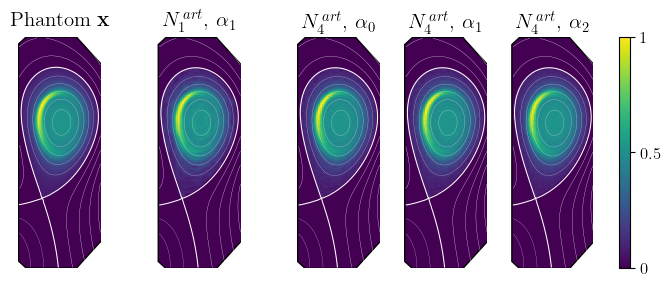

In [27]:
sample_downscaled = skimt.resize(sample, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')
psi_downscaled = skimt.resize(psi, uq_data_idx["im_MAP"].shape, anti_aliasing=False, mode='edge')

std_max = 0.25

# create figure
nb_subplots = 5
fig_width = 1.6*(nb_subplots)
width_ratios = [1]*nb_subplots
width_ratios = [1, 0.1, 1, 0.1, 1, 1, 1.525]
fig, ax = plt.subplots(1, 7, figsize=(fig_width, 3), width_ratios=width_ratios)
plt.subplots_adjust(wspace=0.35)
ax_counter = 0

tomo_plots.plot_profile(sample, tcv_plot_clip=True, contour_image=psi,
                             ax=ax[0], colorbar=False, contour_color="w", vmax=1, aspect="auto", levels=12)
ax[0].set_title(r"$\mathrm{Phantom}\;\mathbf{x}$", fontsize=15, y=1.01)

ax[1].axis("off")

tomo_plots.plot_profile(maps_art[0], tcv_plot_clip=True, contour_image=psi_downscaled,
                             ax=ax[2], colorbar=False, contour_color="w", vmax=1, aspect="auto", levels=12)
ax[2].set_title(r"$N_1^{\,art},\,\alpha_1$", fontsize=15, y=1.01)

ax[3].axis("off")

tomo_plots.plot_profile(maps_art[1], tcv_plot_clip=True, contour_image=psi_downscaled, levels=12,vmax=1, aspect="auto",
               ax=ax[4], colorbar=False, contour_color="w")
ax[4].set_title(r"$N_4^{\,art},\,\alpha_0$", fontsize=15)


tomo_plots.plot_profile(maps_art[2], tcv_plot_clip=True, contour_image=psi_downscaled, levels=12,vmax=1, aspect="auto",
               ax=ax[5], colorbar=False, contour_color="w")
ax[5].set_title(r"$N_4^{\,art},\,\alpha_1$", fontsize=15)

cbar_tick_params={"labelsize":12, "yticks":[0,0.5,1], "yticklabels":[r"$0$",  r"$0.5$", r"$1$"]}
tomo_plots.plot_profile(maps_art[3], tcv_plot_clip=True, contour_image=psi_downscaled, levels=12,vmax=1, aspect="auto",
               ax=ax[6], colorbar=True, contour_color="w", cbar_tick_params=cbar_tick_params, pad_cbar=0.2)
ax[6].set_title(r"$N_4^{\,art},\,\alpha_2$", fontsize=15)

plt.savefig('../figures/art_diag_limitations.eps', format='eps', bbox_inches="tight")

plt.show()

In [28]:
for i in range(4):
    print(maps_art_stats[i])
    print("\n")

[0.02074408 0.23225617]


[0.01561198 0.31449349]


[0.01535625 0.31409482]


[0.00977881 0.28793545]


